In [1]:
%matplotlib inline
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from analysis import samples_df
from analysis.result_parsing import pairwise_sig_top_genes
from analysis.plotting import plot_overlap
from analysis.plotting import plot_barplot_intersection
from analysis.plotting import plot_barplot_tissues

# Pairwise TCGA Tumor vs Normal Analysis

Using data produced from this experiment: <br>
https://github.com/jvivian/rnaseq-recompute-analysis/blob/master/experiments/pairwise_tcga.py

## Number of Samples

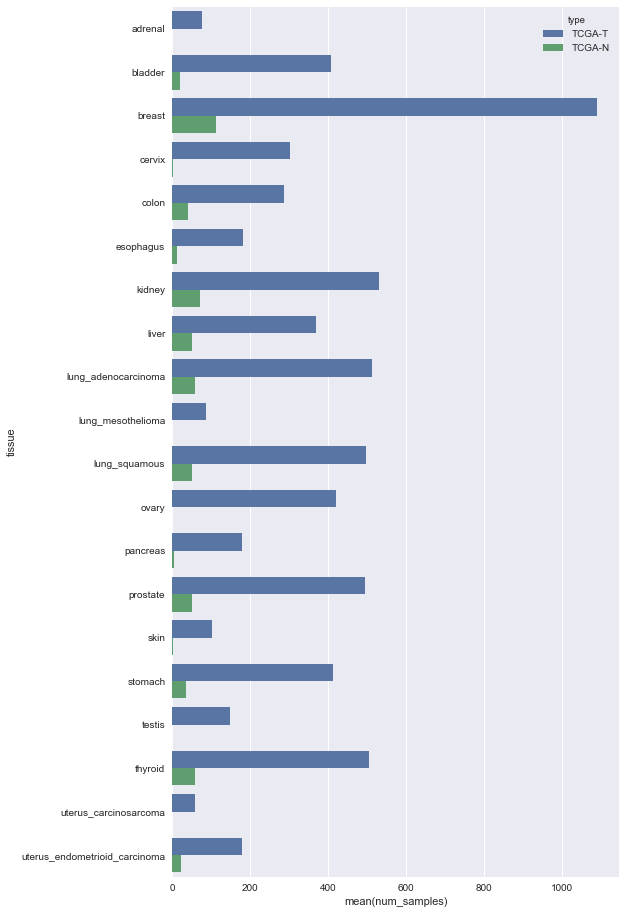

In [2]:
df = pd.DataFrame()
df['tissue'] = list(samples_df.index) * 2
df['num_samples'] = list(samples_df.tcga_t) + list(samples_df.tcga_n)
df['type'] = ['TCGA-T'] * 20 + ['TCGA-N'] * 20

f, ax = plt.subplots(figsize=(8,16))
sns.barplot('num_samples', 'tissue', hue='type', data=df, ax=ax);

Based on the number of samples, we probably shouldn't expect good results for:
- Adrenal
- Cervix
- Lung_mesothelioma
- Ovary
- Pancreas
- Skin
- Testis
- Uterus_carcinosarcoma

Based on number of GTEx samples, we probably shouldn't expect good results for:
- Bladder
- Cervix
- Kidney (probably)

Which leaves:
- Breast
- Colon
- Esophagus
- Liver
- Lung_adenocarcinoma
- Lung_squamous
- Prostate
- Stomach
- Thyroid
- Uterus_endometrioid


## Significant Genes

For comparing pariwise TCGA to Pairwise TCGA-GTEx we'll use `t` to denote the first and `tg` to denote the second.

In [3]:
tissues = list(samples_df.index)
results_t = {}  # pairwise tcga
results_tg = {}  # pairwise tcga-gtex
for t in tissues:
    results_t[t] = pd.read_csv('results/' + t + '-results.tsv', index_col=0, sep='\t')
    results_tg[t] = pd.read_csv('../pairwise-gtex-tcga/results/' + t + '-results.tsv', index_col=0, sep='\t')

In [4]:
t_sig_up, t_sig_down, t_top_up, t_top_down, t_top = pairwise_sig_top_genes(results_t, tissues)
tg_sig_up, tg_sig_down, tg_top_up, tg_top_down, tg_top = pairwise_sig_top_genes(results_tg, tissues)

### Relationship Between Significant Genes and Sample Size

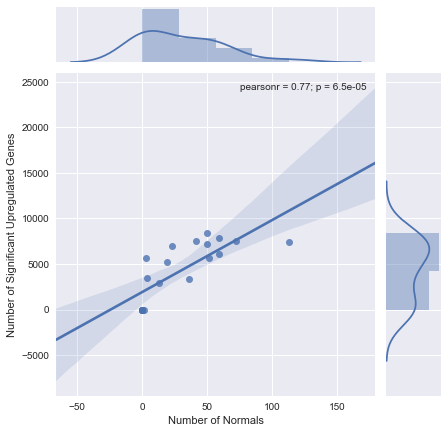

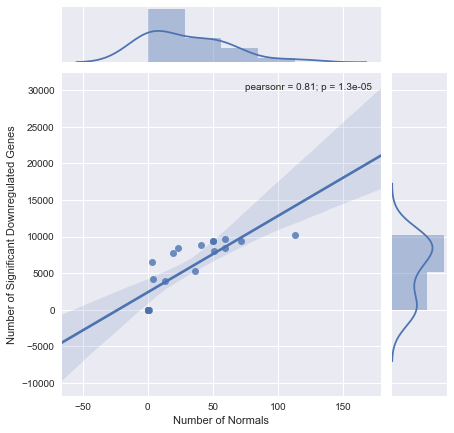

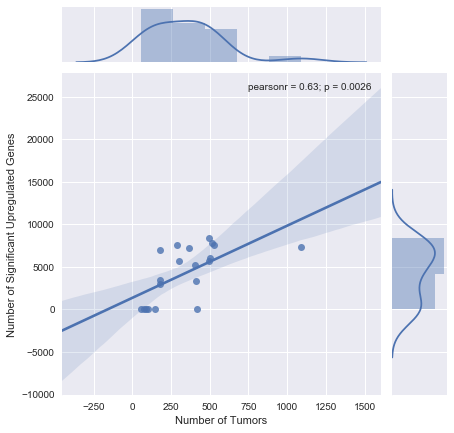

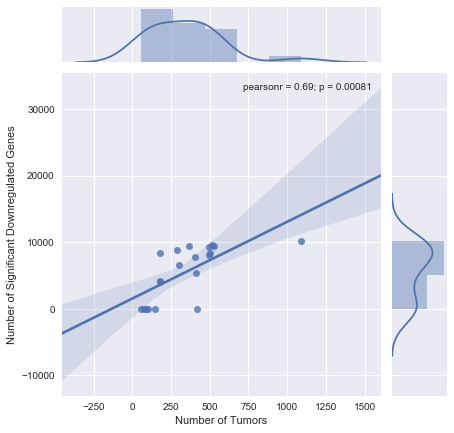

In [5]:
num_sig_up = np.array([len(t_sig_up[x]) for x in tissues]) 
num_sig_down = np.array([len(t_sig_down[x]) for x in tissues])
num_normals = np.array(samples_df.tcga_n)
num_tumor = np.array(samples_df.tcga_t)

sns.jointplot(num_normals, num_sig_up, kind='reg')
plt.xlabel('Number of Normals')
plt.ylabel('Number of Significant Upregulated Genes')
sns.jointplot(num_normals, num_sig_down, kind='reg')
plt.xlabel('Number of Normals')
plt.ylabel('Number of Significant Downregulated Genes')
sns.jointplot(num_tumor, num_sig_up, kind='reg')
plt.xlabel('Number of Tumors')
plt.ylabel('Number of Significant Upregulated Genes')
sns.jointplot(num_tumor, num_sig_down, kind='reg')
plt.xlabel('Number of Tumors')
plt.ylabel('Number of Significant Downregulated Genes')

Let's add in the number of significant genes and samples from the GTEx experiment. 

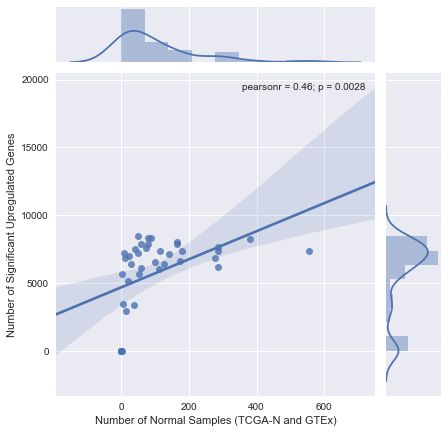

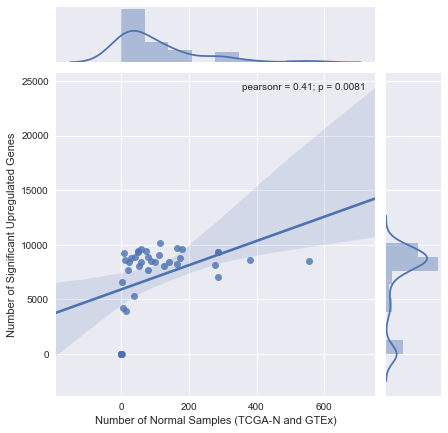

In [6]:
num_sig_up = np.array([len(t_sig_up[x]) for x in tissues] + [len(tg_sig_up[x]) for x in tissues])
num_sig_down = np.array([len(t_sig_down[x]) for x in tissues] + [len(tg_sig_down[x]) for x in tissues])
num_normals = np.array(list(samples_df.tcga_n) + list(samples_df.gtex))

sns.jointplot(num_normals, num_sig_up, kind='reg')
plt.xlabel('Number of Normal Samples (TCGA-N and GTEx)')
plt.ylabel('Number of Significant Upregulated Genes')

sns.jointplot(num_normals, num_sig_down, kind='reg')
plt.xlabel('Number of Normal Samples (TCGA-N and GTEx)')
plt.ylabel('Number of Significant Upregulated Genes')

### Number of Significant Genes Between TCGA and TCGA-GTEx

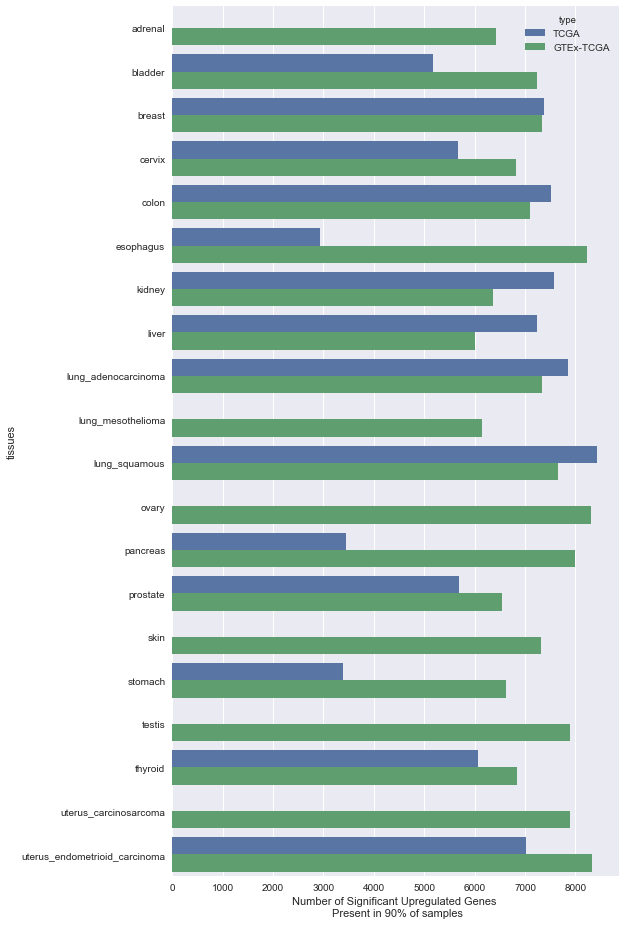

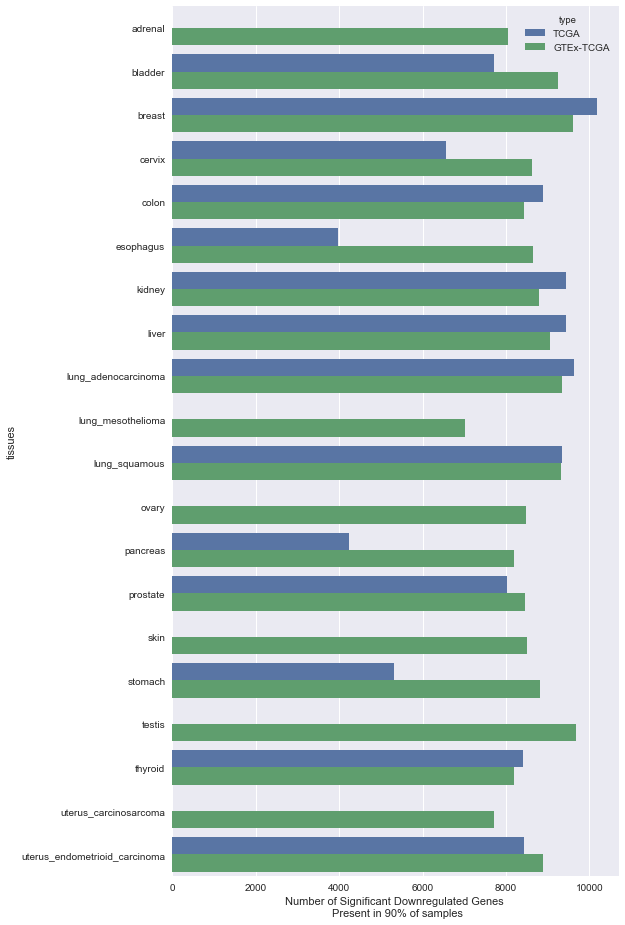

In [7]:
df = pd.DataFrame()
df['num_sig_up'] = [len(t_sig_up[x]) for x in tissues] + [len(tg_sig_up[x]) for x in tissues]
df['num_sig_down'] = [len(t_sig_down[x]) for x in tissues] + [len(tg_sig_down[x]) for x in tissues]
df['tissues'] = tissues * 2
df['type'] = ['TCGA'] * 20 + ['GTEx-TCGA'] * 20

f, ax = plt.subplots(figsize=(8, 16))
sns.barplot('num_sig_up', 'tissues', hue='type', data=df, ax=ax)
plt.xlabel('Number of Significant Upregulated Genes \n Present in 90% of samples')

f, ax = plt.subplots(figsize=(8, 16))
sns.barplot('num_sig_down', 'tissues', hue='type', data=df, ax=ax)
plt.xlabel('Number of Significant Downregulated Genes \n Present in 90% of samples')

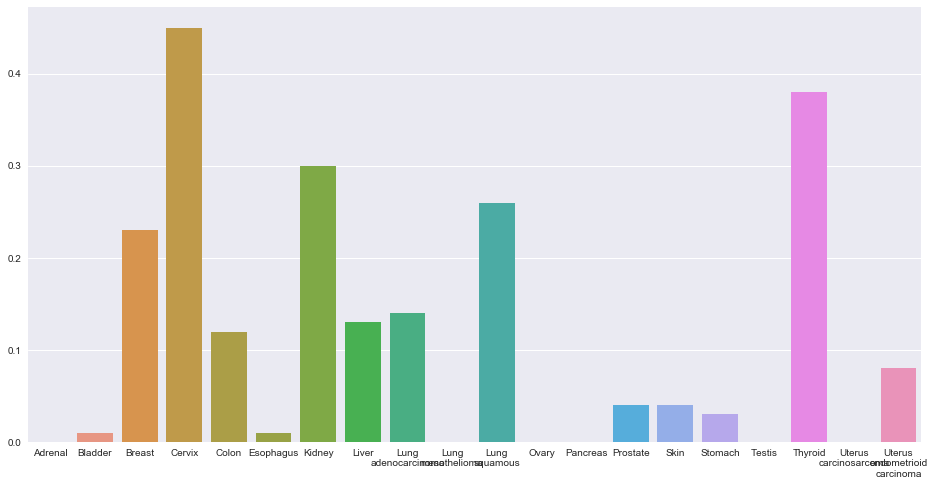

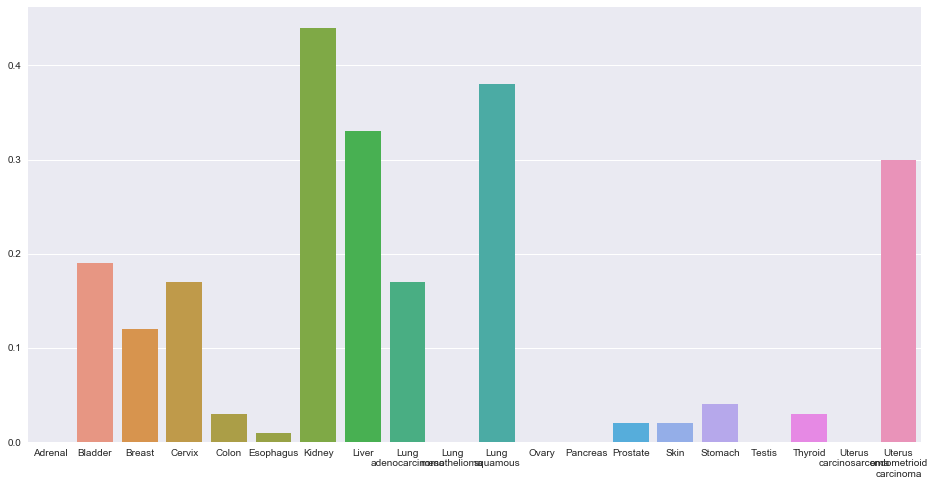

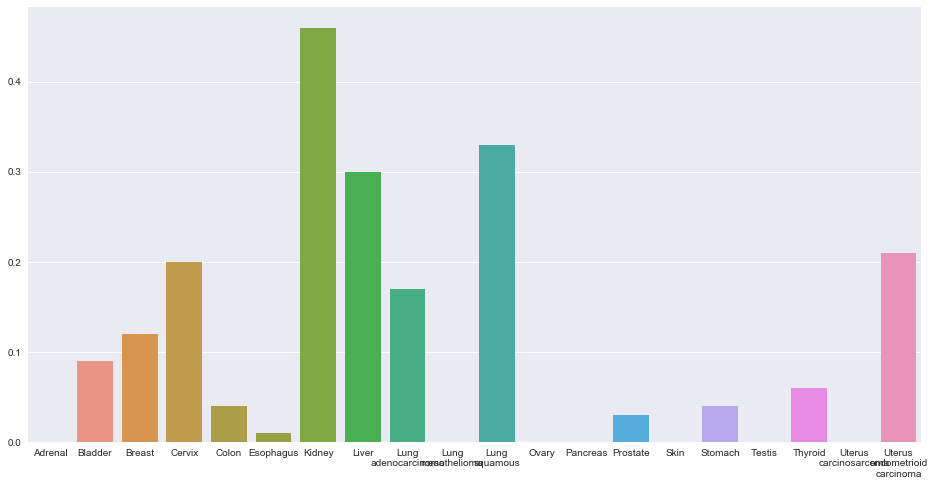

In [9]:
plot_barplot_intersection(t_top_up, tg_top_up)
plot_barplot_intersection(t_top_down, tg_top_down)
plot_barplot_intersection(t_top, tg_top)

### Write out Analysis

In [10]:
try:
    os.mkdir('analysis')
    os.mkdir('analysis/sig-genes')
    os.mkdir('analysis/top-100-genes')
    os.mkdir('analysis/annotations')
except OSError:
    pass

In [11]:
for t in tissues:
    up_genes = t_top_up[t]
    down_genes = t_top_down[t]
    sig_up = t_sig_up[t]
    sig_down = t_sig_down[t]
    top = t_top[t]
    
    with open('analysis/top-100-genes/' + t + '.txt', 'w') as f:
        f.write('\n'.join(top))
    with open('analysis/top-100-genes/' + t + '-upreg.txt', 'w') as f:
        f.write('\n'.join(up_genes))
    with open('analysis/top-100-genes/' + t + '-downreg.txt', 'w') as f:
        f.write('\n'.join(down_genes))
    with open('analysis/sig-genes/' + t + '-upreg.txt', 'w') as f:
        f.write('\n'.join(sig_up))
    with open('analysis/sig-genes/' + t + '-downreg.txt', 'w') as f:
        f.write('\n'.join(sig_down))
